# Load Library & Preprocess Data

In [1]:
import random, os, math
from datetime import datetime
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import cv2
from tqdm import tqdm
from math import floor
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import datasets
from tensorflow.keras.preprocessing.image import ImageDataGenerator


### Set Seed

In [2]:
SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed_everything(SEED)

In [3]:
TRAIN_ROOT_PATH = f'../../Datasets/mpii_human_pose_v1'
pd.set_option('display.max_columns', None)
df_ = pd.read_csv(TRAIN_ROOT_PATH + f'/mpii_human_pose_v1_u12_2/mpii_dataset.csv')
df_ = df_.iloc[:, 1:-3]

df_ = df_.iloc[:, [0, 13, 14, 5, 6, 3, 4, 1, 2, 7, 8, 9, 10, 11, 12,
                  15, 16, 17, 18, 19, 20, 27, 28, 29, 30, 31, 32, 25, 26, 23, 24, 21, 22]]
spine = (np.array(df_.iloc[:, [15, 16]]) +  np.array(df_.iloc[:, [1, 2]])) // 2
df_ = pd.concat([df_, pd.DataFrame(spine)], axis=1)
df = df_.iloc[:, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
                 33, 34, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]]
df.rename(columns={0:'spine_X', 1:'spine_Y'}, inplace=True)
df.iloc[:, 0] = TRAIN_ROOT_PATH + f'/images/' + df.iloc[:, 0]
df.head()

,NAME,pelvis_X,pelvis_Y,r hip_X,r hip_Y,r knee_X,r knee_Y,r ankle_X,r ankle_Y,l hip_X,l hip_Y,l knee_X,l knee_Y,l ankle_X,l ankle_Y,spine_X,spine_Y,thorax_X,thorax_Y,upper neck_X,upper neck_Y,head top_X,head top_Y,l shoulder_X,l shoulder_Y,l elbow_X,l elbow_Y,l wrist_X,l wrist_Y,r shoulder_X,r shoulder_Y,r elbow_X,r elbow_Y,r wrist_X,r wrist_Y
0,../../Datasets/mpii_human_pose_v1/images/01560...,610,187,573,185,616,269,620,394,647,188,661,221,656,231,628,181,647,176,637.0201,189.8183,695.9799,108.1817,692,185,693,240,688,313,601,167,553,161,606,217
1,../../Datasets/mpii_human_pose_v1/images/01559...,763,568,806,543,-1,-1,-1,-1,720,593,-1,-1,-1,-1,723,429,683,290,682.0000,256.0000,676.0000,68.0000,719,299,711,516,545,466,647,281,555,410,563,296
2,../../Datasets/mpii_human_pose_v1/images/00580...,974,446,908,438,816,510,804,711,1040,454,906,528,883,707,979,349,985,253,982.7591,235.9694,962.2409,80.0306,1067,253,1167,353,1142,478,902,253,798,340,869,214
3,../../Datasets/mpii_human_pose_v1/images/08661...,248,341,201,340,305,375,301,461,294,342,335,370,331,455,263,302,279,263,277.0210,268.7786,305.9790,184.2214,314,264,327,320,362,346,244,261,260,335,328,354
4,../../Datasets/mpii_human_pose_v1/images/06011...,904,237,865,248,896,318,980,322,943,226,948,290,881,349,881,186,858,135,871.1877,180.4244,835.8123,58.5756,923,123,995,163,961,223,792,147,754,247,772,294


### Split train & test Data 

In [4]:
train_df, validation_df = train_test_split(df, test_size=0.3, random_state=SEED)

# Utils 

In [5]:
def normalize_image(image):
    mean = [0.40789655, 0.44719303, 0.47026116]
    std = [0.2886383, 0.27408165, 0.27809834]
    return ((np.float32(image) / 255.) - mean) / std

def heatmap(keypoints, input_size, output_width=32, output_height=32, sigma=1):
    
    heatmap_result = np.zeros((output_width, output_height, 17))
    offset_result = np.zeros((output_width, output_height, 34))
    displacement_fwd_result = np.zeros((output_width, output_height, 32))
    displacement_bwd_result = np.zeros((output_width, output_height, 32))
    resize_rate_w = output_width / input_size[1]
    resize_rate_h = output_height / input_size[0]
    
    def get_coords(keypoints):
        keypoints = keypoints.reshape(17, 2)
        x_radius = (np.max(keypoints[:,0]) - np.min(keypoints[:,0])) / 8
        y_radius = (np.max(keypoints[:,1]) - np.min(keypoints[:,1])) / 8
        return keypoints, x_radius, y_radius
    
    def get_heatmap(p_x, p_y, sigma):
        X1 = np.linspace(1, output_width, output_height)
        Y1 = np.linspace(1, output_width, output_height)
        [X, Y] = np.meshgrid(X1, Y1)
        X = X - floor(p_x)
        Y = Y - floor(p_y)
        D2 = X * X + Y * Y
        E2 = 2.0 * sigma ** 2
        Exponent = D2 / E2
        heatmap = np.exp(-Exponent)
        heatmap = heatmap[:, :, np.newaxis]
        return heatmap
    
    def get_offset(x, y, x_radius, y_radius):
        x_radius = np.max([2, floor(x_radius * resize_rate_h)])
        y_radius = np.max([2, floor(y_radius * resize_rate_w)])
        offset_x = np.zeros((output_width, output_height))
        offset_y = np.zeros((output_width, output_height))
        p_x = floor(x * resize_rate_w)
        p_y = floor(y * resize_rate_h)
        for idx in range(output_width):
            # x - (p_x / resize_rate_w) + (1 / resize_rate_w) * (idx - p_x)
            # y - (p_y / resize_rate_h) + (1 / resize_rate_h) * (idx - p_y)
            if p_y - y_radius <= idx <= p_y + y_radius:
                offset_x[idx,p_x - x_radius:p_x + x_radius] = y - idx / resize_rate_h
            if p_x - x_radius <= idx <= p_x + x_radius:
                offset_y[p_y - y_radius:p_y + y_radius,idx] = x - idx / resize_rate_w
        return offset_x, offset_y
    
    keypoints, x_radius, y_radius = get_coords(keypoints)
    
    for idx, keypoint in enumerate(keypoints):
        if -1 in keypoint: continue
        heatmap = get_heatmap(keypoint[0] * resize_rate_w,
                              keypoint[1] * resize_rate_h,
                              sigma)
        heatmap_result[:,:,idx] = np.maximum(heatmap_result[:,:,idx], heatmap[:,:,0])
        
        offset_x, offset_y = get_offset(keypoint[0], keypoint[1], x_radius, y_radius)
        offset_result[:,:,idx] = offset_x
        offset_result[:,:,17 + idx] = offset_y
    
    return heatmap_result, offset_result, displacement_fwd_result, displacement_bwd_result

In [9]:
def draw_heatmap(heatmap_result, offset_result, displacement_fwd_result, displacement_bwd_result):
        
    plt.figure(figsize=(10, 30))
    
    ### Heatmap
    for idx in range(17):
        plt.subplot(12,5,idx+1)
        plt.imshow(heatmap_result[0][:,:,idx])
        plt.title(idx)

    
    ### Offset
    for idx in range(17):
        plt.subplot(12,5,idx+1+20)
        plt.imshow(offset_result[0][:,:,idx])
        plt.colorbar()
        plt.title(idx)
        plt.subplot(12,5,idx+18+20)
        plt.imshow(offset_result[0][:,:,17+idx])
        plt.colorbar()
        plt.title(17+idx)
        plt.show

# Datagenerator 

In [10]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, list_IDs, df, batch_size=4, shuffle=True,
                 random_state=42, image_paths=None, mode='fit',):
        self.list_IDs = list_IDs
        self.df = df
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.random_state = random_state
        self.image_paths = image_paths
        self.mode = mode
        
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))
    
    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        
        list_IDs_batch = [self.list_IDs[i] for i in indexes]

        X, img_hs, img_ws = self.__generate_X(list_IDs_batch)
        
        if self.mode == 'fit':
            y = self.__generate_y(list_IDs_batch, img_hs, img_ws)
            return X, y
        
        elif self.mode == 'predict':
            return X
        
        else:
            raise AttributeError('The mode parameter should be set to "fit" or "predict".')
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.seed(self.random_state)
            np.random.shuffle(self.indexes)[:,:]
            
    def __generate_X(self, list_IDs_batch):
        X = []
        img_ws = []
        img_hs = []
        for i, ID in enumerate(list_IDs_batch):
            img_path = self.image_paths[ID]
            img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB).astype(np.float32)
            img /= 255.
            img_hs.append(img.shape[0])
            img_ws.append(img.shape[1])
            print(f'image shape : {img.shape}')
            plt.imshow(img)
            X.append(img)
        X = np.array(X)
        return X, img_hs, img_ws
    
    def __generate_y(self, list_IDs_batch, img_hs, img_ws):
        heatmap_result = []
        offset_result = []
        displacement_fwd_result = []
        displacement_bwd_result = []
        for i, ID in enumerate(list_IDs_batch):
            print('ID : ', ID)
            keypoints = df[df.index == ID].iloc[:, 1:].to_numpy()[0]
            hm, offset, _, _ = heatmap(keypoints, input_size=(img_hs[i], img_ws[i]))
            heatmap_result.append(hm)
            offset_result.append(offset)
            # displacement_fwd_result.append(displacement_fwd)
            # displacement_bwd_result.append(displacement_bwd)
            
        heatmap_result = np.array(heatmap_result)
        offset_result = np.array(offset_result)
        # displacement_fwd_result = np.array(displacement_fwd_result)
        # displacement_bwd_result = np.array(displacement_bwd_result)
        
        return [heatmap_result, offset_result, displacement_fwd_result, displacement_bwd_result]

image shape : (480, 640, 3)
ID :  6332


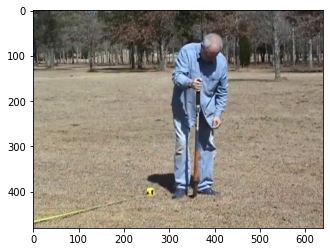

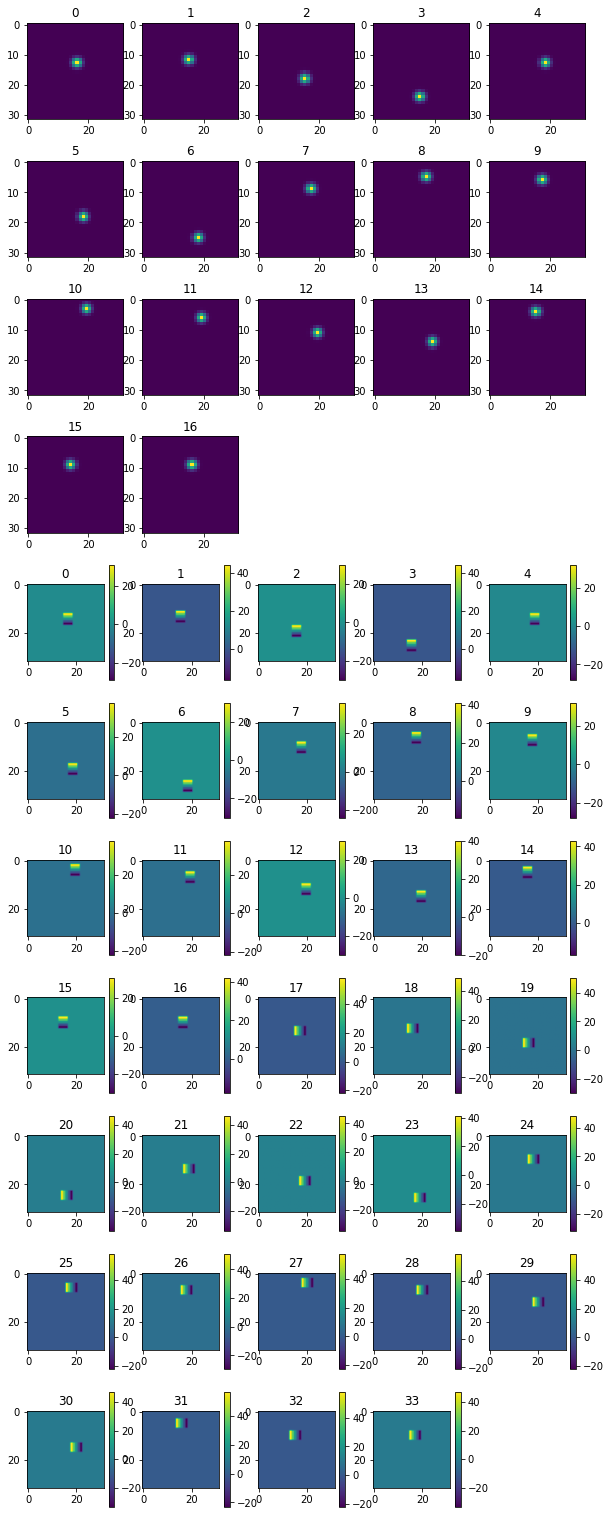

In [11]:
train_gen = DataGenerator(
    list_IDs = train_df.index,
    df = df,
    batch_size = 1,
    shuffle = False,
    image_paths = train_df['NAME'],
    mode = 'fit',
)

img, regr = train_gen.__getitem__(1)
draw_heatmap(*regr)

### Hyperparameter, Config, Callback

In [ ]:
### Multi GPU ###
strategy = tf.distribute.MirroredStrategy()
print("Number of device : {}".format(strategy.num_replicas_in_sync))

### config ###
y_col = ['l ankle_X', 'l ankle_Y', 'r knee_X', 'r knee_Y', 'r hip_X',
       'r hip_Y', 'pelvis_X', 'pelvis_Y', 'r ankle_X', 'r ankle_Y', 'l hip_X',
       'l hip_Y', 'l knee_X', 'l knee_Y', 'spine_X', 'spine_Y', 'thorax_X',
       'thorax_Y', 'upper neck_X', 'upper neck_Y', 'head top_X', 'head top_Y',
       'r shoulder_X', 'r shoulder_Y', 'r elbow_X', 'r elbow_Y', 'r wrist_X',
       'r wrist_Y', 'l wrist_X', 'l wrist_Y', 'l elbow_X', 'l elbow_Y',
       'l shoulder_X', 'l shoulder_Y']

### Hyperparameter ###
EPOCH = 1000
initial_epoch = 0
learning_rate = 0.001
test_size = 0.3
target_size = (256, 256 ,3)
batch_size = 32
dropout_rate = 0.2

loss_object = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate)
# optimizer = tf.keras.optimizers.SGD(learning_rate)
metrics = ['mse']

patience = 10 # Early Stop patience

### Callback ###
# Tensorboard
logdir = os.path.join('logs', datetime.now().strftime(f'%Y%m%d-%H%M%S'))
tensorboard = tf.keras.callbacks.TensorBoard(
    logdir,
    histogram_freq=1,
    write_graph=True,
    write_images=True,
)

# Learningrate scheduler
def scheduler(epoch):
    if epoch < 10: return 0.001
    else: return 0.001 * math.exp(0.1 * (10 - epoch))
learning_rate_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)

# Checkpoint
ckpt_dir = f'chechpoints'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    ckpt_dir,
    monitor='mse',
    verbose=1,
    save_best_only=True,
)

# Early stop
early_stop = tf.keras.callbacks.EarlyStopping('mse', patience=patience, verbose=1)

callbacks = [tensorboard, checkpoint, early_stop]

# DataGenerator

In [ ]:
train_df, validation_df = train_test_split(df, test_size=test_size, random_state=SEED)

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255.,
)
validation_datagen = ImageDataGenerator(
    rescale=1./255.,
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='NAME',
    y_col=y_col,
    target_size=target_size[:2],
    batch_size=batch_size,
    class_mode='multi_output',
    shuffle=True,

)

validation_generator = validation_datagen.flow_from_dataframe(
    validation_df,
    x_col='NAME',
    y_col=y_col,
    traget_size=target_size[:2],
    batch_size=batch_size,
    class_mode='multi_output',
)

# Build Model

In [ ]:
from tensorflow.keras.applications import ResNet50, resnet

In [ ]:
class PoseNet:
    def __init__(self, target_size, dropout_rate, optimizer, loss_object, metrics):
        self.target_size = target_size
        self.dropout_rate = dropout_rate
        self.optimizer = optimizer
        self.loss_object = loss_object
        self.metrics = metrics

    def createBaseModel(self):
        base_model = ResNet50(
            input_shape=self.target_size,
            include_top=False,
            weights='imagenet'
        )
        return base_model

    def createPreprocessInput(self):
        preprocess_input = resnet.preprocess_input
        return preprocess_input

    def __call__(self):
        base_model = self.createBaseModel()
        base_model.trainable = False
        preprocess_input = self.createPreprocessInput()

        inputs = tf.keras.Input(shape=self.target_size)
        x = preprocess_input(inputs)
        x = base_model(x, training=False)
        outputs = tf.keras.activations.sigmoid(x)

        model = tf.keras.Model(inputs, outputs)
        model.compile(
            optimizer=self.optimizer,
            loss=self.loss_object,
            metrics=self.metrics,
        )
        return model

In [ ]:
# with strategy.scope():
with tf.device('/device:GPU:1'):
    model = PoseNet(target_size, dropout_rate, optimizer, loss_object, metrics)
    model = model()
    model.summary()

In [ ]:
image = cv2.imread(f'../../Datasets/images/skiing.jpg', cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
image /= 255.
plt.imshow(image)
plt.show()

In [ ]:
plt.imshow(model(image[tf.newaxis, ...])[0][:,:,1024])
plt.show()

In [ ]:
model(image[tf.newaxis, ...])[0][:,:,1024].shape, image.shape

In [ ]:
loss, acc = model.evaluate(validation_generator)
print("initial loss: {:.2f}".format(loss))

In [ ]:
history = model.fit(
    train_generator,
    batch_size=batch_size,
    epochs=EPOCH,
    callbacks=callbacks,
    validation_data=validation_generator,
    steps_per_epoch=len(train_generator) // 2,
    validation_steps=len(validation_generator) // 2,
)
